In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# infile ='../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5'
# infile = '../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5'

infile = '../../NEXT_nudobe/files/data/mbb_0_2  mm_smear_1bar.h5'

hits = pd.read_hdf(infile,"MC/hits")
parts = pd.read_hdf(infile,"MC/particles")

display(hits)


,event_id,x,y,z,energy
0,25,-103.788467,-259.872833,-263.172668,0.000200
1,25,-103.984810,-263.174255,-262.906189,0.001075
2,25,-103.730209,-256.456940,-262.309570,0.000350
3,25,-103.719986,-254.491684,-261.696869,0.001200
4,25,-103.769035,-265.105286,-261.419434,0.001100
...,...,...,...,...,...
28572,46,577.331970,-2125.871094,1058.827271,0.008200
28573,46,577.748596,-2126.235840,1058.893799,0.001050
28574,46,578.989197,-2126.995361,1060.532104,0.007625
28575,46,578.727905,-2124.666260,1061.315552,0.047400


Energy Sum:  2.4591002


,x,y,z,energy
0,-172.685944,3.055179,-482.496063,0.017000
1,-172.417297,3.140550,-481.679901,0.016525
2,-171.982376,2.557860,-476.387848,0.002225
3,-171.713272,2.220174,-486.305115,0.000275
4,-170.516174,3.077127,-471.601227,0.000850
...,...,...,...,...
1129,302.769043,-51.336739,-148.825714,0.000900
1130,328.796143,-198.094193,-242.766632,0.004400
1131,332.434052,-198.303986,-241.175217,0.034750
1132,333.308350,-199.001175,-242.397659,0.004150


Vertex Index is: 575


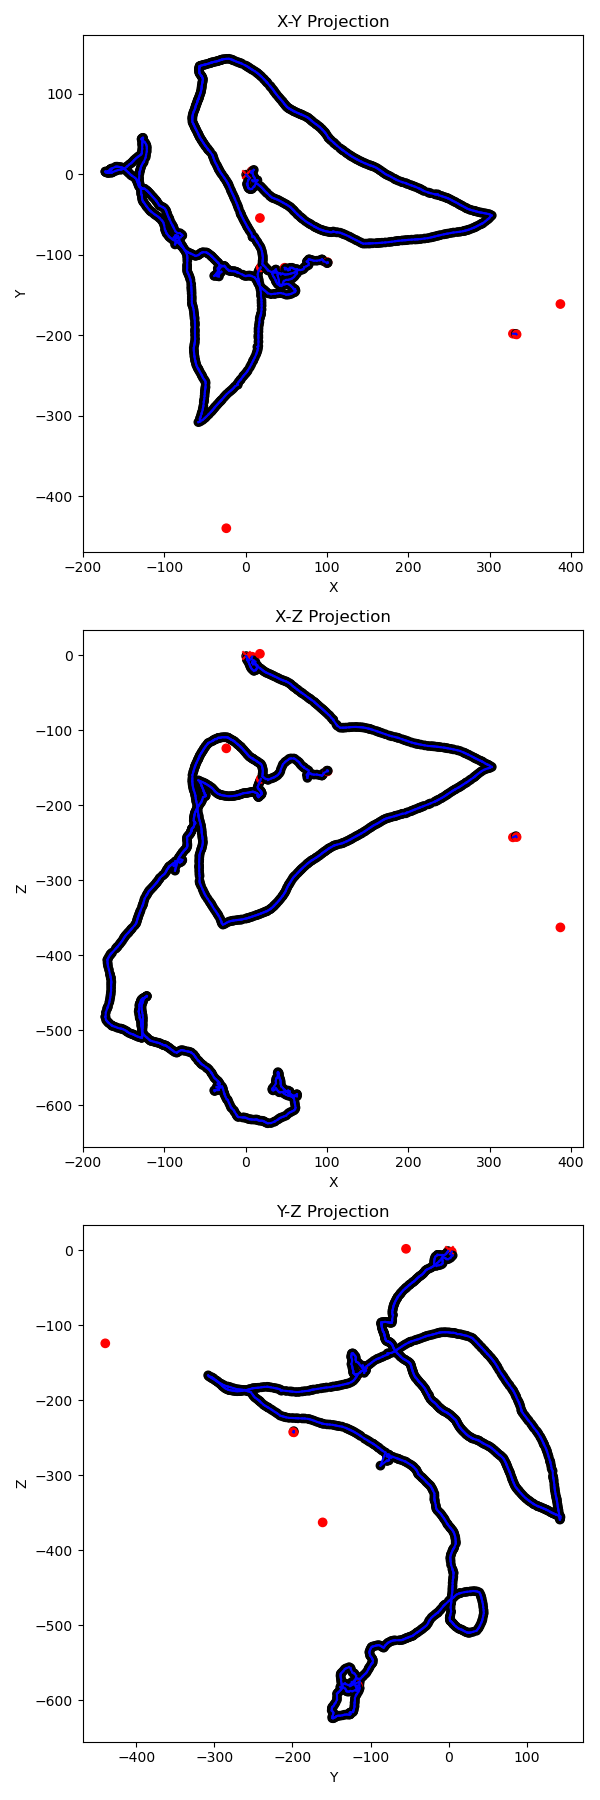

In [69]:
%matplotlib widget

event_num = 27

data = hits[hits.event_id == event_num]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# In the case of nexus, set the vertex to origin
if ("nexus" in infile):
    vertex = pd.DataFrame({'event_id': [event_num], 'x': [0], 'y': [0], 'z': [0], 'energy': [0]})
    data = pd.concat([data, vertex], ignore_index=True)

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
# data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    # ax.set_xlim(-50,50)
    # ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 576, 'end': 611, 'nodes': [576, 575, 580, 588, 597, 591, 583, 581, 585, 586, 592, 594, 598, 602, 603, 610, 624, 628, 636, 640, 642, 648, 646, 637, 621, 612, 634, 633, 627, 623, 620, 613, 617, 625, 605, 607, 611], 'length': 90.667, 'energy': 0.1670750004814181, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 635, 'end': 951, 'nodes': [635, 643, 655, 677, 688, 701, 711, 715, 719, 722, 726, 731, 734, 738, 745, 753, 764, 773, 786, 796, 804, 813, 820, 830, 840, 843, 851, 855, 861, 865, 873, 880, 881, 886, 889, 891, 894, 898, 904, 911, 912, 916, 921, 922, 923, 927, 929, 932, 934, 939, 941, 945, 947, 953, 956, 959, 960, 961, 965, 967, 968, 971, 973, 975, 978, 980, 983, 986, 988, 991, 993, 995, 998, 1000, 1002, 1004, 1006, 1009, 1012, 1014, 1016, 1020, 1023, 1026, 1029, 1031, 1032, 1035, 1037, 1039, 1042, 1044, 1047, 1049, 1050, 1054, 1057, 1058, 1061, 1062, 1063, 1066, 1068, 1070, 1073, 1075, 1078, 1081, 1084, 1087, 1

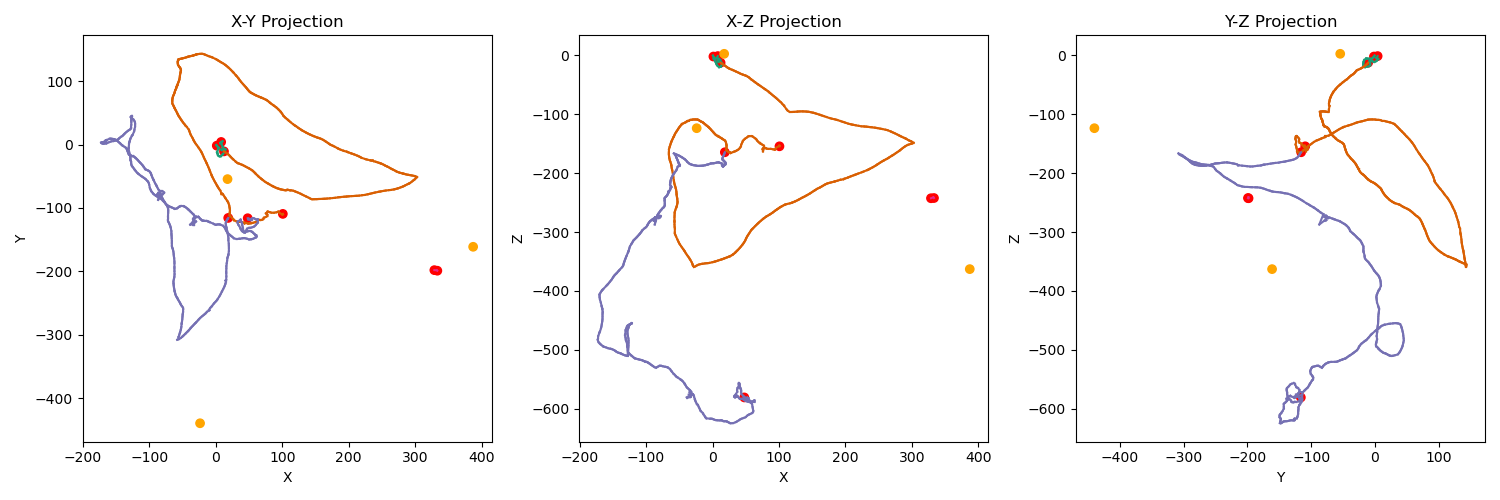

In [70]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [71]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

2.628


In [72]:
# Now look to merge tracks that are close by and identify deltas

# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)

# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        print("vertex:",vertex_index)
        print("Path1:",trk1_path)
        print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks, data)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------



vertex: 575
Path1: [575, 576]
Path2: [575, 580, 588, 597, 591, 583, 581, 585, 586, 592, 594, 598, 602, 603, 610, 624, 628, 636, 640, 642, 648, 646, 637, 621, 612, 634, 633, 627, 623, 620, 613, 617, 625, 605, 607, 611]
Printing Tracks
{'id': 2, 'start': 635, 'end': 951, 'nodes': [635, 643, 655, 677, 688, 701, 711, 715, 719, 722, 726, 731, 734, 738, 745, 753, 764, 773, 786, 796, 804, 813, 820, 830, 840, 843, 851, 855, 861, 865, 873, 880, 881, 886, 889, 891, 894, 898, 904, 911, 912, 916, 921, 922, 923, 927, 929, 932, 934, 939, 941, 945, 947, 953, 956, 959, 960, 961, 965, 967, 968, 971, 973, 975, 978, 980, 983, 986, 988, 991, 993, 995, 998, 1000, 1002, 1004, 1006, 1009, 1012, 1014, 1016, 1020, 1023, 1026, 1029, 1031, 1032, 1035, 1037, 1039, 1042, 1044, 1047, 1049, 1050, 1054, 1057, 1058, 1061, 1062, 1063, 1066, 1068, 1070, 1073, 1075, 1078, 1081, 1084, 1087, 1090, 1093, 1095, 1096, 1100, 1101, 1104, 1106, 1108, 1110, 1112, 1114, 1116, 1118, 1119, 1121, 1123, 1124, 1126, 1128, 1129, 1127, 1

2
2.6704199682932654
83.06885098917229
Connecting Track ID is: 11
Connecting:  635 637
3
4.6703789436021115
329.72318839667867
Connecting Track ID is: 2
Connecting:  689 710
6
138.56195232419995
137.29278521972017
138.56195232419995 137.29278521972017 10.512
Failed distance requirements
7
142.68560834305836
142.68560834305836
407.2962647936378 407.2962647936378 10.512
Failed distance requirements
8
40.65915660061374
40.65915660061374
407.2962647936378 407.2962647936378 10.512
Failed distance requirements
9
137.29278521972017
137.29278521972017
137.29278521972017 137.29278521972017 10.512
Failed distance requirements
10
3.058118144669127
1.0355799862866009
56.4605983305356 55.38981164202132 10.512
Failed distance requirements
11
2.0232271028556497
8.831859540251145
19.506953972515596 19.1086624217539 10.512
Failed distance requirements
12
Skipping Vertex...
{'id': 2, 'start': 637, 'end': 951, 'nodes': [637, 635, 643, 655, 677, 688, 701, 711, 715, 719, 722, 726, 731, 734, 738, 745, 753, 

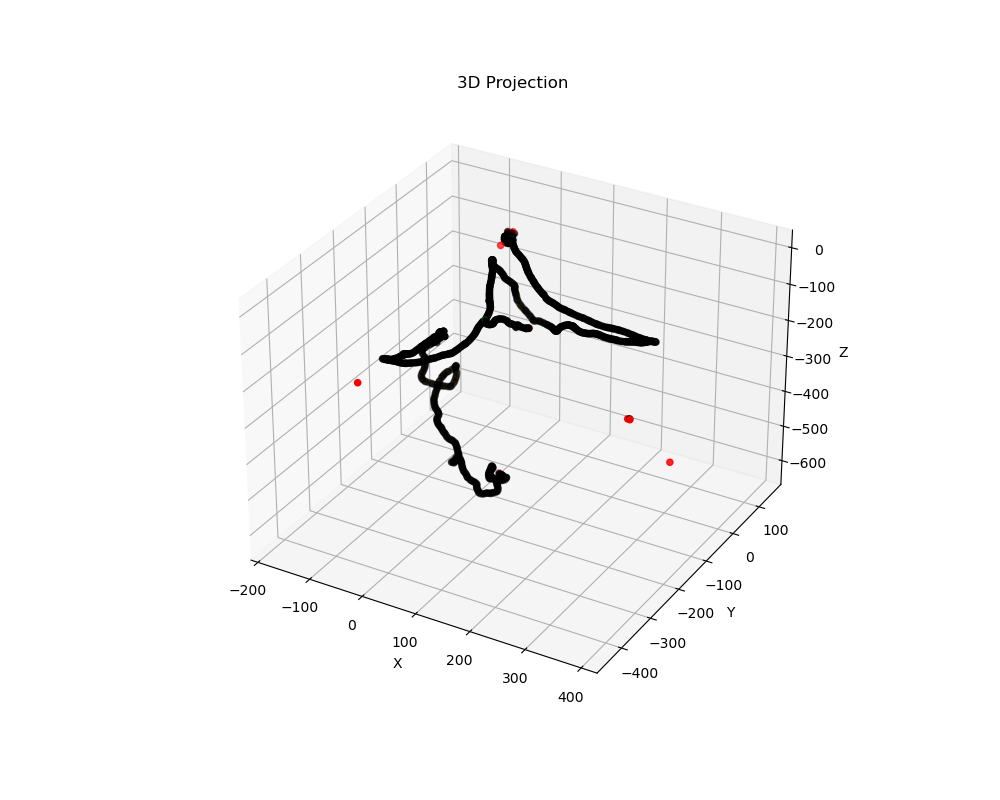

In [73]:
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    curr_label = Track["label"]

    if (curr_label== "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    print(dist_matrix[start_node][dist_ind_start[0]])
    print(dist_matrix[end_node][dist_ind_end[0]])

    # if we have a primary track, then filter the vertex node and the other primary track nodes
    dist_ind_start, dist_ind_end = FilterNodes(dist_ind_start, dist_ind_end, curr_label, UpdatedTracks)

    # After filtering, if no candidate nodes left, then continue
    if (len(dist_ind_start) == 0):
        continue

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print(dist_start, dist_end, dist_threshold)
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Get the track labels of the connecting track
    start_con_track_label = GetTrackDictwithNode(dist_ind_start[0], Tracks)["label"]
    end_con_track_label   = GetTrackDictwithNode(dist_ind_end[0], Tracks)["label"]

    # Choose the smallest index
    if ( (dist_start < dist_end or dist_ind_end[0] == vertex_index)):
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)
    print("Connecting Track ID is:",con_track_dict["id"])

    if (con_track_dict == -1):
        print("Connecting track could not be found...")
        continue

    # The current node should not have more than 2 connections as its an end
    # The connecting node should not have more than 3 connections
    if (connection_count[closest_idx] >= 3 or connection_count[end_conn_node] >= 2):
        print("node already has three connecitons,skipping...")
        continue

    # if node-node then merge nodes and update track in Tracks
    # if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
        
    #     Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)
    #     newpath = join_tracks(Track["nodes"],con_track_dict["nodes"])
    #     UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
    #     UpdateConnections(end_conn_node, closest_idx, connected_nodes, connections, connection_count)
    #     print("node-node connection",curr_track,con_track  )
    #     continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        print("Connecting: ",end_conn_node, closest_idx)
        UpdateConnections(end_conn_node,closest_idx, connected_nodes, connections, connection_count)
    else:
        continue


    Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)

    # Combine the track labels
    AddConnectedTracksnoDelta(curr_track, con_track, UpdatedTracks)


FixTrackEnergies(UpdatedTracks,vertex_index, data)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

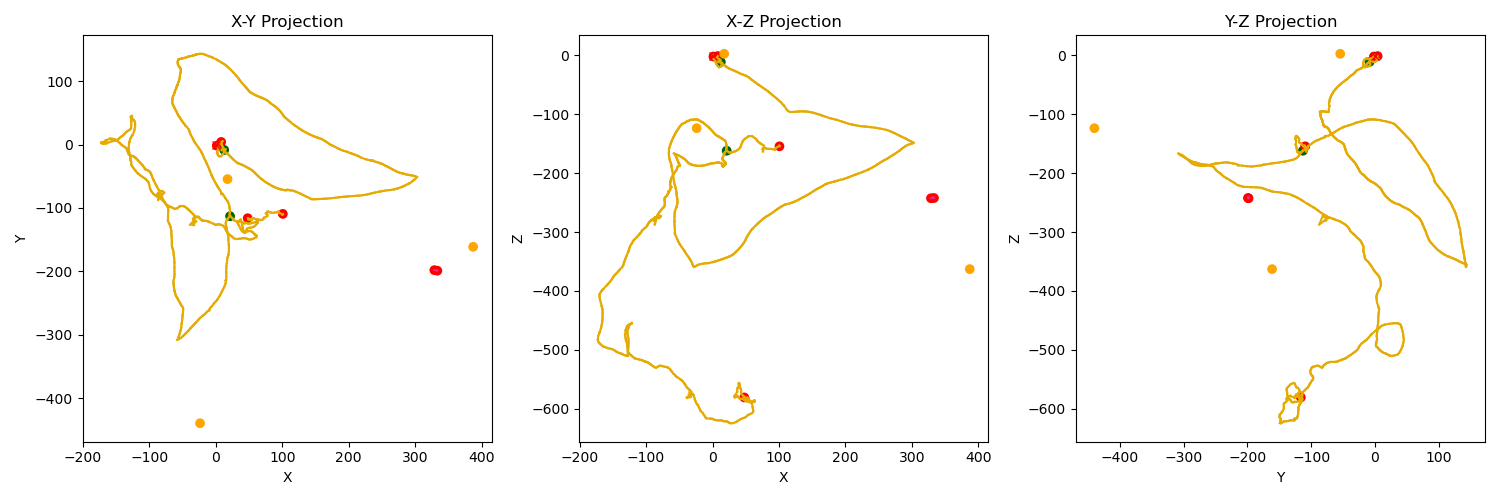

In [74]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', UpdatedTracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', UpdatedTracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', UpdatedTracks)

plt.tight_layout()
plt.show()

### Reconstruction level quantities

In [75]:
track1_energy = 0
track2_energy = 0

# This adds each gamma/track energy to the closest track instead. 
for t in UpdatedTracks:

    if (t["label"] == "Track1"):
        track1_energy = track1_energy + t["energy"]

    if (t["label"] == "Track2"):
        track2_energy = track2_energy + t["energy"]

    if (t["label"] != "Track1" and t["label"] != "Track2" and t["label"] != "vertex"):

        print(t["label"])
        # Get the indexes of closest nodes to start of the gamma
        dist_ind_start = np.argsort(dist_matrix[t["start"]])[1:]

        # Filter nodes that are in the current track
        dist_ind_start = [x for x in dist_ind_start if x not in t["nodes"]]

        found_Track = False

        # Loop over the the closest indexes
        for d_idx in dist_ind_start:

            if (found_Track):
                break

            # Loop over the tracks
            for closest_t in UpdatedTracks:
                if (d_idx in closest_t["nodes"] and closest_t["label"] == "Track1"):
                    # print("Adding Gamma energy", t["energy"] ,"to Track1")
                    track1_energy = track1_energy + t["energy"]
                    found_Track = True
                    break

                if (d_idx in closest_t["nodes"] and closest_t["label"] == "Track2"):
                    # print("Adding Gamma energy", t["energy"] ,"to Track2")
                    track2_energy = track2_energy + t["energy"]
                    found_Track = True
                    break


print("Track 1 Energy:", track1_energy)
print("Track 2 Energy:", track2_energy)
print("Tot Energy:", track1_energy + track2_energy)
Reco_T1 = ReturnLargest(track1_energy,track2_energy)


part = parts[parts.event_id == event_num]
part = part[part.primary == 1]
display(part)

gen_kin_energy = max(part.kin_energy.values) # generator T1


track
gamma
gamma
gamma
Track 1 Energy: 0.002999999967869371
Track 2 Energy: 2.456100008708745
Tot Energy: 2.4591000086766144


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
1204,27,2,e-,1,0,0.0,0.0,0.0,0.0,48.044132,...,1.390147,-1.528783,-1.783507,0.0,-0.0,0.0,2.265997,2823.704590,none,eIoni
2025,27,1,e-,1,0,0.0,0.0,0.0,0.0,6.219865,...,0.182750,-0.284738,-0.344364,-0.0,-0.0,0.0,0.191980,99.184006,none,eIoni


In [76]:
# Calculate the angle between the electrons

### ------------- ------------- ------------- -------------
# Filter particles with particle_id 1 and 2
particle_1 = part[part.particle_id == 1].copy()
particle_2 = part[part.particle_id == 2].copy()

# Merge the DataFrames on 'event' to pair particles from the same event
merged_particles = pd.merge(particle_1, particle_2, on="event_id", suffixes=('_1', '_2'))

# Apply the function to each row in the merged DataFrame
merged_particles['angle'] = merged_particles.apply(calculate_angle_parts, axis=1)
print("True Angle:", merged_particles['angle'].iloc[0])
# ------------- ------------- ------------- -------------

data['Track1'] = 0
data['Track2'] = 0

track1_indices = []
track2_indices = []

for t in UpdatedTracks:

    if t["label"] == "Track1":
        track1_indices = track1_indices + t["nodes"]

    if t["label"] == "Track2":
        track2_indices = track2_indices + t["nodes"]

data.loc[track1_indices, 'Track1'] = 1
data.loc[track2_indices, 'Track2'] = 1

display(data[data.distance < 5])

print(track1_indices)


True Angle: 0.9892163790660986


,x,y,z,energy,distance,Track1,Track2
575,0.645684,-0.731184,-0.939667,0.001850,1.354442,1,1
576,1.375891,-1.742704,-2.532486,0.002075,3.368023,1,0
580,1.710638,-2.285649,-3.348318,0.001550,4.400194,0,1


[575, 576]


In [77]:
# Given vertex position
vertex = data[ (data.Track1 == 1) & (data.Track2 == 1)]
vertex = np.array([vertex.iloc[0].x,vertex.iloc[0].y,vertex.iloc[0].z])
vertex = np.array([0,0,0])

# Track1 = data[ (data.Track1 == 1) & (data.Track2 != 1)]
Track1 = data.iloc[trk1_path]
# Track1 = Track1.reindex(track1_indices)
Track1 = Track1.iloc[1:] # remove vertex index

# Track2 = data[ (data.Track2 == 1) & (data.Track1 != 1)]
Track2 = data.iloc[trk2_path]
# Track2 = Track2.reindex(track2_indices)
Track2 = Track2.iloc[1:] # remove vertex index

display(Track1)
display(Track2)

# cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1.iloc[0:1], Track2.iloc[0:1], vertex)
cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1, Track2, vertex)

print(cos_theta)

,x,y,z,energy,distance,Track1,Track2
576,1.375891,-1.742704,-2.532486,0.002075,3.368023,1,0


,x,y,z,energy,distance,Track1,Track2
580,1.710638,-2.285649,-3.348318,0.001550,4.400194,0,1
588,3.068067,-3.745976,-4.998267,0.004100,6.959026,0,1
597,4.620088,-5.362642,-6.372250,0.001475,9.524112,0,1
591,3.168709,-7.527118,-6.136306,0.003075,10.215306,0,1
583,2.033283,-11.712126,-6.126741,0.000050,13.373297,0,1
581,1.725616,-12.126104,-6.181868,0.001250,13.719899,0,1
585,2.346783,-13.955235,-5.992820,0.000050,15.367820,0,1
586,2.403714,-14.107380,-5.991204,0.000050,15.514205,0,1
592,3.168814,-16.781719,-8.256723,0.015700,18.969475,0,1
594,4.180986,-17.708515,-10.477483,0.000850,20.996424,0,1


0.9986916531391544


(-2.0, 2.0)

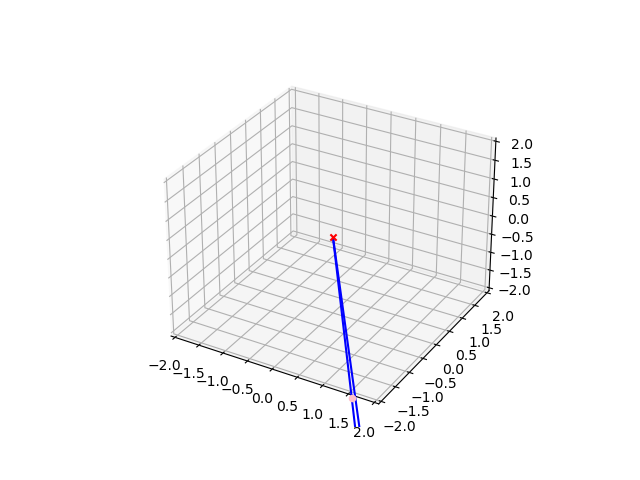

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
# ax.scatter(data.x, data.y, data.z, color='blue')
ax.scatter(vertex[0], vertex[1], vertex[2], color='red', marker="x")
ax.scatter(Track1.x, Track1.y, Track1.z, color='pink')
ax.scatter(Track2.x, Track2.y, Track2.z, color='green')

# Plot the direction vector
vector_line1 = np.array([vertex, vertex + 10*direction_vector1])  # Extend the vector for visualization
vector_line2 = np.array([vertex, vertex + 10*direction_vector2])  # Extend the vector for visualization

ax.plot(vector_line1[:, 0], vector_line1[:, 1], vector_line1[:, 2], color='blue')
ax.plot(vector_line2[:, 0], vector_line2[:, 1], vector_line2[:, 2], color='blue')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)